# Pipeline from Pyphysio for EDA signals

Divide the pipelines into three separate steps:
0. import data;
1. Filtering and Preprocessing: this step includes all the procedures aiming at increasing the signal/noise ratio, typycally band-pass filtering, smoothing, removal of artifacts. The output of this step is a new version of the imput signal with improved signal quality (less noise);
2. Information Extraction: this step aims at extracting the information of interest from the physiological signal. The output is a new signal containing only the information of interest and thus it has a **signal_nature** different from the input signal.
3. Physiological Indicators: this steps produces a list of scalar values able to describe the characteristics of the input signal. This step is usually performed on small segments of the input signals which are extracted using a sliding window on the whole length of the signal.

![algorithm](img/flowchart_processing.png)

*Figure 1: Representation of the three main steps of a signal processing pipeline. Below: example of the ideal results of each block on a Photo-PlethysmoGraph (PPG) signal. *

### Step 0: Import data

In [1]:
# import libraries
import numpy as np
import os
import matplotlib.pyplot as plt

%matplotlib inline 

# import all pyphysio classes and methods
import pyphysio as ph
from pyphysio import EvenlySignal, UnevenlySignal
import pyphysio.filters.Filters as flt
import pyphysio.estimators.Estimators as est

Please cite:
Bizzego et al. (2019) 'pyphysio: A physiological signal processing library for data science approaches in physiology', SoftwareX


Sampling frequency: 50
Start time:         100
End time:           132.20000000000002
Duration:           32.20000000000002
Signal type  :      eda
First ten instants: [100.   100.02 100.04 100.06 100.08 100.1  100.12 100.14 100.16 100.18]


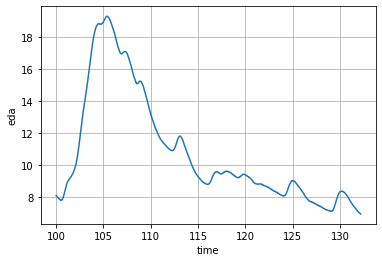

In [22]:
# import data and creating a signal
my_eda_data = np.loadtxt(fname = os.getcwd()+'/11.txt')
# /Users/gioelepozzi/Desktop/code/eda_feature_extraction/11.txt

fsamp = 50 # from the paper
eda = ph.EvenlySignal(values = my_eda_data, sampling_freq = fsamp, signal_type = 'eda', start_time=100)

# check signal properties
print('Sampling frequency: {}'.format( eda.get_sampling_freq() ))
print('Start time:         {}'.format( eda.get_start_time() ))
print('End time:           {}'.format( eda.get_end_time() ))
print('Duration:           {}'.format( eda.get_duration() ))
print('Signal type  :      {}'.format( eda.get_signal_type() ))
print('First ten instants: {}'.format( eda.get_times()[0:10] ))

# plot the signal
eda.plot()

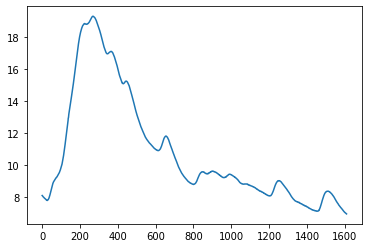

In [23]:
plt.plot(eda.segment_time(100, 200))

Managing the sampling frequency
The sampling frequency of a signal is defined before the acquisition. However it is possible to numerically change it in order to oversample or downsample the signal, according to the signal type and characteristics.

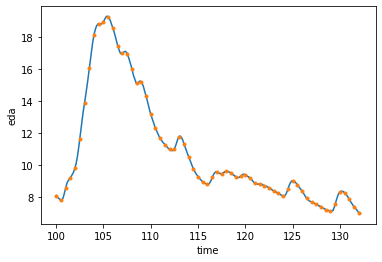

In [24]:
# resampling
eda_resampled = eda.resample(fout=2) # fout: sampling frequency for resampling

eda.plot() # plotting the original signal
eda_resampled.plot('.') # plotting the samples of the downsampled signal

eda = eda_resampled

### Step 1: Filtering and preprocessing

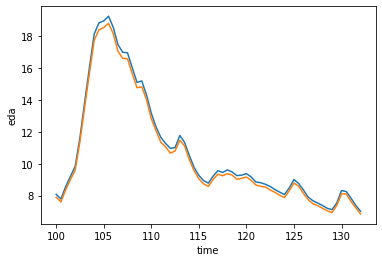

In [25]:
# IIR filtering : remove high frequency noise
# lowpass filter of 0.6 Hz to diminuish the noise from motion and artifacts as said in the paper

# fp: list of float the pass frequencies
# fs: listo fo float the stop frequencies
# ftype: type of filter

eda_filt = flt.IIRFilter(fp=0.8, fs = 1.1, ftype='ellip')(eda)

eda.plot()
eda_filt.plot()

eda = eda_filt

### Step 2: Information Extraction

The information we want to extract from the EDA signal is the phasic component associated to the sympathetic activity.
Estimators are algorithms which aim at extracting the information of interest from the input signal, thus returning a new signal which has a different `signal_nature`. 

In [26]:
# estimate the driver function

driver = est.DriverEstim()(eda)

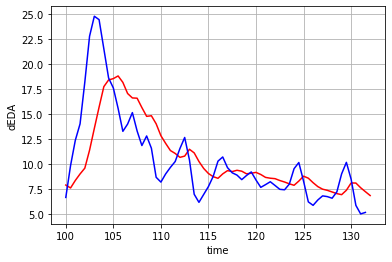

In [27]:
eda.plot('r')
driver.plot('b')
plt.grid()

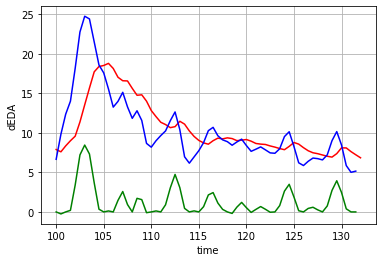

In [28]:
# compute the phasic component
phasic, tonic, _ = ph.PhasicEstim(delta=0.02)(driver)
eda.plot('r')
driver.plot('b')
phasic.plot('g')


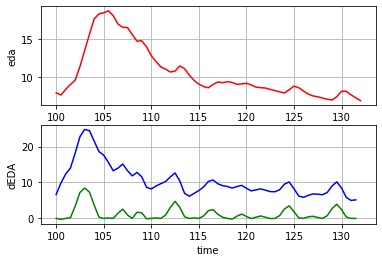

In [29]:
# check results so far
plt.figure()
ax1 = plt.subplot(211)
eda.plot('r')

plt.subplot(212, sharex = ax1)
driver.plot('b')
phasic.plot('g')
plt.grid()
plt.show()

The information we want to extract from the EDA signal is the phasic component associated to the sympathetic activity.

### Step 3: Physiological Indicators

Indicators are algorithm which extract a metrics (scalar value) from the input signal, for instance a statistic average.

In [30]:
# create an Indicator
import pyphysio.indicators.TimeDomain as td_ind
import pyphysio.indicators.FrequencyDomain as fd_ind

In [31]:
# time domain indicators

# arithmetic mean of the signal
td_mean = td_ind.Mean() # create the indicator
td_mean_ = td_mean(phasic)
print('mean: ', td_mean_)

# min and max
td_min = td_ind.Min()
td_min_ = td_min(phasic)
print('min: ', td_min_)
td_max = td_ind.Max()
td_max_ = td_max(phasic)
print('max: ', td_max_)

# range
td_range = td_ind.Range()
td_range_ = td_range(phasic)
print('range: ', td_range_)

# median
td_median = td_ind.Median()
td_median_ = td_median(phasic)
print('median: ', td_median_)

# standard deviation
td_stdev = td_ind.StDev()
td_stdev_ = td_stdev(phasic)
print('standard deviation: ', td_stdev_)

# sum ov the values in the signal
td_sum = td_ind.Sum()
td_sum_ = td_sum(phasic)
print('sum: ', td_sum_)

# AUC: area under the curve of the signal
td_AUC = td_ind.AUC()
td_AUC_ = td_AUC(phasic)
print('AUC: ', td_AUC_)

# RMSSD: square root of the mean of the squared 1st order discrete differences
td_RMSSD = td_ind.RMSSD()
td_RMSSD_ = td_RMSSD(phasic)
print('RMSSD: ', td_RMSSD_)

# SDSD: standard deviation of the 1st order discrete differences
td_SDSD = td_ind.SDSD()
td_SDSD_ = td_SDSD(phasic)
print('SDSD: ', td_SDSD_)


mean:  1.2778023579441058
min:  -0.25297753188072214
max:  8.462434270927599
range:  8.71541180280832
median:  0.4454753184635569
standard deviation:  1.8739224452183671
sum:  81.77935090842277
AUC:  40.889675454211385
RMSSD:  1.3471833011428347
SDSD:  1.3471833011428347


In [32]:
# frequency domain indicators

# extract the PSD (Power Spectral Density) of a given frequency band
fd_inband = fd_ind.InBand(interp_freq=4, freq_max=0.4, freq_min=0.15, method = 'fft') # create the indicator
fd_inband_ = fd_inband(phasic.resample(4)) # resampling needed to compute PSD
# print('PSD: ', fd_inband_) # returns array of frequencies in the frequency band and a float of PSD in the frequency band

# estimation of the power in a given frequency band
fd_powerinband = fd_ind.PowerInBand(interp_freq=4, freq_max=0.4, freq_min=0.15, method = 'fft') # create the indicator
fd_powerinband_ = fd_powerinband(phasic.resample(4)) # resampling needed to compute PSD
print('Power inband: ', fd_powerinband_)

# estimation of the peak frequency in a given frequency band
fd_peakinband = fd_ind.PeakInBand(interp_freq=4, freq_max=0.4, freq_min=0.15, method = 'fft') # create the indicator
fd_peakinband_ = fd_peakinband(phasic.resample(4)) # resampling needed to compute PSD
print('Peak inband: ', fd_peakinband_)

Power inband:  531.323810036354
Peak inband:  0.234375


In [34]:
#fixed length windowing
fixed_length = ph.FixedSegments(step = 1, width = 20)

# we use the preset indicators for the phasic signal.
# We need to define the minimum amplitude of the peaks that will be considered
PHA_ind, col_names = ph.fmap(fixed_length, ph.preset_phasic(delta=0.02), phasic)

If you need to export the results, for instance in a .csv datafile, you can use `pandas`:

In [35]:
import pandas as pd

# create a pandas dataframe
PHA_DF = pd.DataFrame(PHA_ind, columns=col_names)

PHA_DF

,begin,end,label,pha_Mean,pha_StDev,pha_Range,pha_PeaksMax,pha_PeaksMin,pha_PeaksMean,pha_PeaksNum,pha_DurationMean,pha_SlopeMean,pha_AUC
0,100,120,None,1.48696,2.15692,8.71541,8.46243,0,2.25961,9,1.83333,2.13221,29.7391
1,101,121,None,1.50515,2.1456,8.65241,8.46243,0.123425,2.39342,9,1.94444,2.05022,30.1029
2,102,122,None,1.5251,2.13453,8.65241,8.46243,0.123425,2.39342,9,1.88889,1.71445,30.502
3,103,123,None,1.26677,1.9201,8.65241,8.46243,0.123425,2.22194,10,1.8,1.52057,25.3353
4,104,124,None,0.891961,1.17402,4.93575,4.74577,0.123425,1.74355,10,1.8,1.52057,17.8392
5,105,125,None,0.944476,1.19099,4.93575,4.74577,0.123425,1.52855,9,1.83333,1.67978,18.8895
6,106,126,None,0.992324,1.18959,4.93575,4.74577,0.124987,1.90299,9,1.94444,1.71368,19.8465
7,107,127,None,0.96684,1.19015,4.93575,4.74577,0.124987,1.90299,9,1.94444,1.64814,19.3368
8,108,128,None,0.900271,1.16737,4.93575,4.74577,0.124987,1.68164,9,2,1.29157,18.0054
9,109,129,None,0.876079,1.16011,4.93575,4.74577,0.124987,1.66325,9,1.94444,1.29157,17.5216


In [260]:
# and save it to a .csv file:

PHA_DF.to_csv('filename.csv')